In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [23]:
# Step 1: Define the Assets
assets = [
    "SPY",  # S&P 500 ETF
    "QQQ",  # Nasdaq 100 ETF
    "VTI",  # Total US Stock Market ETF
    "VB",   # Small-Cap ETF
    "TLT",  # Long-Term Treasury Bond ETF
    "BWX",  # International Treasury Bond ETF
    "IWM",  # Russell 2000 ETF (US Small-Cap)
    "CDP",  # COPT  Defense Properties
    "AAL",  # Airlines
    "AMD",  # Advanced Micro Devices
    "GLD",  # SPDR Gold ETF
    "EEM",  # Emerging Markets ETF
    "IEFA", # International Developed Markets ETF
    "XLK",  # Technology Sector ETF
    "XLE",  # Energy Sector ETF
    "USO",  # Oil Fund
    "DBC",  # Broad Commodities
    "VNQ",  # US Real Estate ETF
    "RWX",  # International Real Estate ETF
    "HDG",  # Hedge Funds Proxy
    "LQD",  # Investment Grade Corporate Bond ETF
    'AMRC',   # Ameresco (small-cap energy)
    'RAMP',   # LiveRamp (niche marketing tech)
    'AXTI',   # AXT Inc. (small-cap semiconductors)
]

# Step 2: Fetch Historical Data
def fetch_data(assets, start_date="2013-01-01", end_date="2023-12-01"):
    """
    Fetch adjusted close prices for the given assets.
    """
    data = {}
    for asset in assets:
        try:
            data[asset] = yf.download(asset, start=start_date, end=end_date)['Adj Close']
        except Exception as e:
            print(f"Failed to fetch {asset}: {e}")
    return pd.DataFrame(data)

price_data = fetch_data(assets)

# Step 3: Check and Handle Missing Data
missing_data_report = price_data.isnull().sum()
print("\nMissing Data Report:")
print(missing_data_report)

# Step 4: Calculate Daily Returns
returns = price_data.pct_change().dropna()

# Step 5: Calculate Expected Returns
def mean_historical_returns(data, freq=252):
    """
    Calculate mean historical returns.
    """
    return data.mean() * freq

expected_returns = mean_historical_returns(returns)
print("\nExpected Returns (Annualized):")
print(expected_returns)

# Step 6: Calculate Risk (Covariance Matrix)
def historical_covariance(data, freq=252):
    """
    Calculate historical covariance matrix.
    """
    return data.cov() * freq

covariance_matrix = historical_covariance(returns)
print("\nCovariance Matrix:")
print(covariance_matrix)

# Helper function to calculate portfolio performance
def portfolio_performance(weights, expected_returns, covariance_matrix):
    """
    Calculate portfolio return and risk.
    """
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_return, portfolio_risk

# Portfolio Optimization Objectives

# Objective 1: Maximize Sharpe Ratio
def maximize_sharpe_ratio(expected_returns, covariance_matrix, risk_free_rate):
    num_assets = len(expected_returns)

    def objective(weights):
        portfolio_return, portfolio_risk = portfolio_performance(weights, expected_returns, covariance_matrix)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk
        return -sharpe_ratio  # Negative for maximization

    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    bounds = [(0, 1) for I in range(num_assets)]
    result = minimize(objective, np.ones(num_assets) / num_assets, bounds=bounds, constraints=constraints)
    return result.x

# Objective 2: Minimize Risk with a Target Return
def minimize_risk_with_target_return(expected_returns, covariance_matrix, target_return):
    num_assets = len(expected_returns)

    def objective(weights):
        _, portfolio_risk = portfolio_performance(weights, expected_returns, covariance_matrix)
        return portfolio_risk  # Minimize risk

    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, expected_returns) - target_return}
    ]
    bounds = [(0, 1) for _ in range(num_assets)]
    result = minimize(objective, np.ones(num_assets) / num_assets, bounds=bounds, constraints=constraints)
    return result.x

# Objective 3: Maximize Return with a Risk Limit
def maximize_return_with_risk_limit(expected_returns, covariance_matrix, risk_limit):
    num_assets = len(expected_returns)

    def objective(weights):
        portfolio_return, _ = portfolio_performance(weights, expected_returns, covariance_matrix)
        return -portfolio_return  # Negative for maximization

    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'ineq', 'fun': lambda weights: risk_limit - np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))}
    ]
    bounds = [(0, 1) for i in range(num_assets)]
    result = minimize(objective, np.ones(num_assets) / num_assets, bounds=bounds, constraints=constraints)
    return result.x

# Risk-Free Rate: US 10-Year Treasury Yield (2013–2023 average)
risk_free_rate = 0.0231  # Example 2.31% (historical average for the 10-Year Treasury)

# Test Target Returns: 5%, 10%, 15%
target_returns = [0.05, 0.10, 0.15, 0.20, 0.35]

# Test Risk Limits: 10%, 15%, 20%
risk_limits = [0.05, 0.10, 0.15, 0.20, 0.35]

# Optimization Results
print("\nOptimizing Portfolio for Different Risk Parameters...\n")

# Maximize Sharpe Ratio
optimal_sharpe_weights = maximize_sharpe_ratio(expected_returns, covariance_matrix, risk_free_rate)

# Minimize Risk with Target Returns
min_risk_weights = {f"Target {tr * 100:.0f}%": minimize_risk_with_target_return(expected_returns, covariance_matrix, tr) for tr in target_returns}

# Maximize Return with Risk Limits
max_return_weights = {f"Risk Limit {rl * 100:.0f}%": maximize_return_with_risk_limit(expected_returns, covariance_matrix, rl) for rl in risk_limits}

# Format Results
def format_weights(weights, decimal_places=4):
    return [round(weight, decimal_places) for weight in weights]

optimal_sharpe_weights = format_weights(optimal_sharpe_weights)
min_risk_weights = {key: format_weights(weights) for key, weights in min_risk_weights.items()}
max_return_weights = {key: format_weights(weights) for key, weights in max_return_weights.items()}

# Display Results
print("\nOptimal Weights for Maximize Sharpe Ratio:")
print(optimal_sharpe_weights)

print("\nOptimal Weights for Minimize Risk with Target Returns:")
for target, weights in min_risk_weights.items():
    print(f"{target}: {weights}")

print("\nOptimal Weights for Maximize Return with Risk Limits:")
for limit, weights in max_return_weights.items():
    print(f"{limit}: {weights}")

# Combine Results into DataFrame
results = pd.DataFrame({
    "Assets": assets,
    "Max Sharpe Ratio": optimal_sharpe_weights,
    **{key: weights for key, weights in min_risk_weights.items()},
    **{key: weights for key, weights in max_return_weights.items()}
})

print("\nComparison of Optimal Portfolios:")
print(results)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


Missing Data Report:
SPY     0
QQQ     0
VTI     0
VB      0
TLT     0
BWX     0
IWM     0
CDP     0
AAL     0
AMD     0
GLD     0
EEM     0
IEFA    0
XLK     0
XLE     0
USO     0
DBC     0
VNQ     0
RWX     0
HDG     0
LQD     0
AMRC    0
RAMP    0
AXTI    0
dtype: int64

Expected Returns (Annualized):
SPY     0.137222
QQQ     0.191741
VTI     0.134026
VB      0.112608
TLT     0.010781
BWX    -0.015608
IWM     0.103232
CDP     0.070812
AAL     0.114409
AMD     0.517375
GLD     0.024546
EEM     0.029400
IEFA    0.066355
XLK     0.205530
XLE     0.092068
USO    -0.050747
DBC     0.003902
VNQ     0.078365
RWX     0.013920
HDG     0.022161
LQD     0.023917
AMRC    0.238010
RAMP    0.144817
AXTI    0.122635
dtype: float64

Covariance Matrix:
           SPY       QQQ       VTI        VB       TLT       BWX       IWM  \
SPY   0.029133  0.033024  0.029618  0.031399 -0.006080  0.001556  0.032209   
QQQ   0.033024  0.043557  0.033570  0.033988 -0.005328  0.001937  0.035081   
VTI   0.029618  

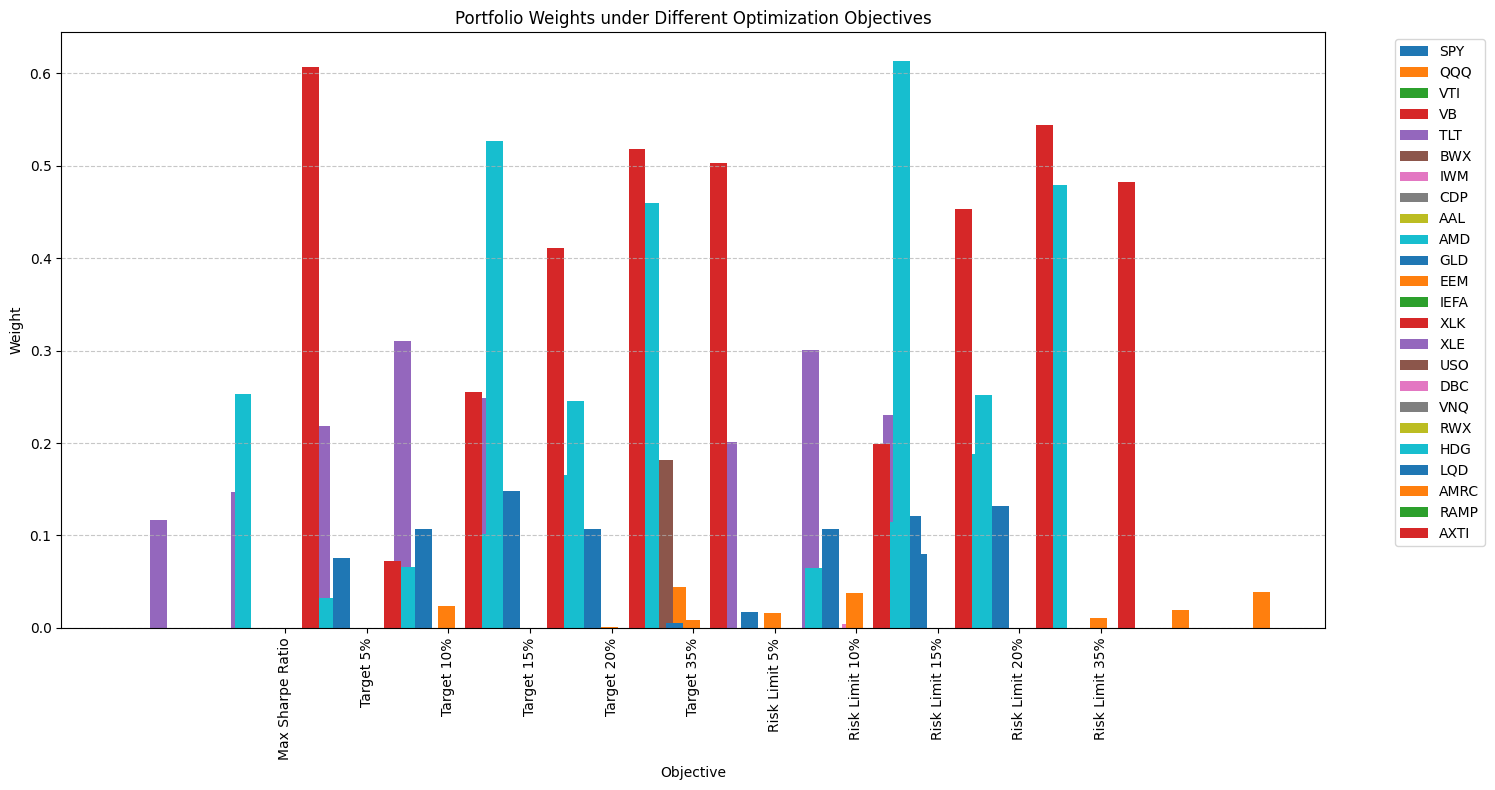

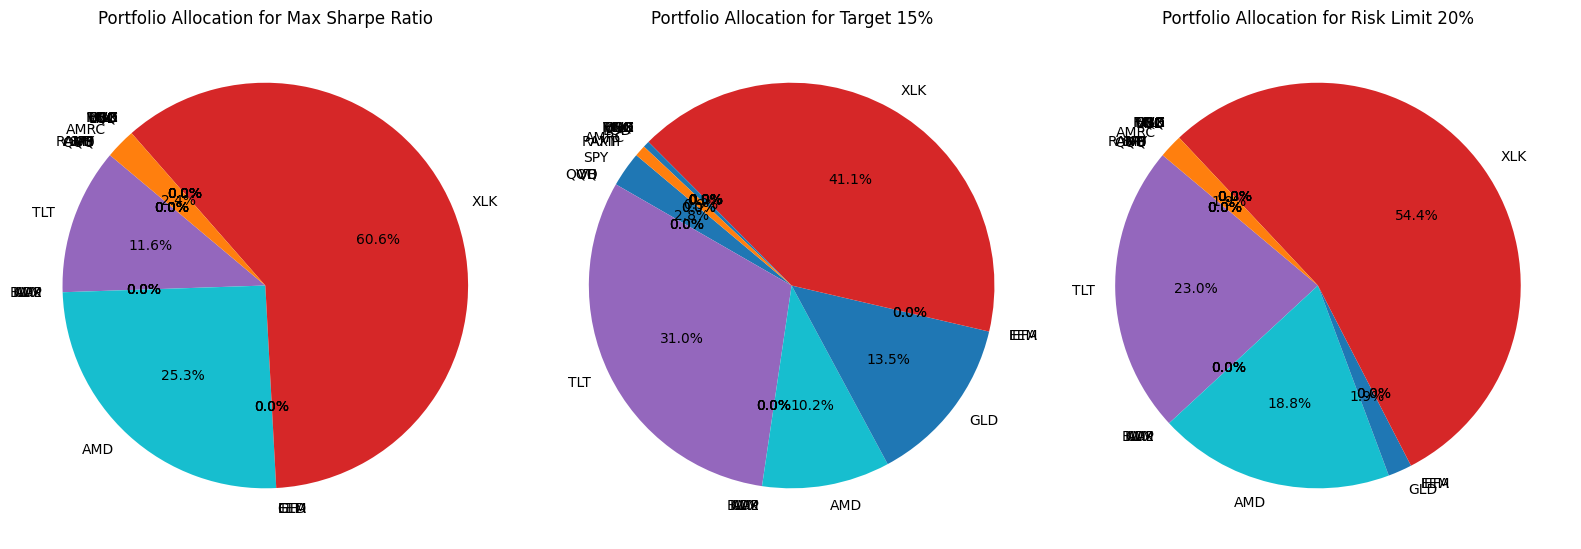

In [24]:
# Extract weights for visualization
weight_df = results.set_index("Assets").T

# Bar plot
weight_df.plot(kind="bar", figsize=(15, 8), width=5.0)
plt.title("Portfolio Weights under Different Optimization Objectives")
plt.ylabel("Weight")
plt.xlabel("Objective")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Define figure and axes for subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

# Pie chart for Max Sharpe Ratio
axes[0].pie(optimal_sharpe_weights, labels=assets, autopct='%1.1f%%', startangle=140)
axes[0].set_title("Portfolio Allocation for Max Sharpe Ratio")

# Pie chart for a specific target return
target_key = "Target 15%"  # Example target
axes[1].pie(min_risk_weights[target_key], labels=assets, autopct='%1.1f%%', startangle=140)
axes[1].set_title(f"Portfolio Allocation for {target_key}")

# Pie chart for a specific risk limit
risk_limit_key = "Risk Limit 20%"  # Example risk limit
axes[2].pie(max_return_weights[risk_limit_key], labels=assets, autopct='%1.1f%%', startangle=140)
axes[2].set_title(f"Portfolio Allocation for {risk_limit_key}")

# Adjust layout and show the figure
plt.tight_layout()
plt.show()




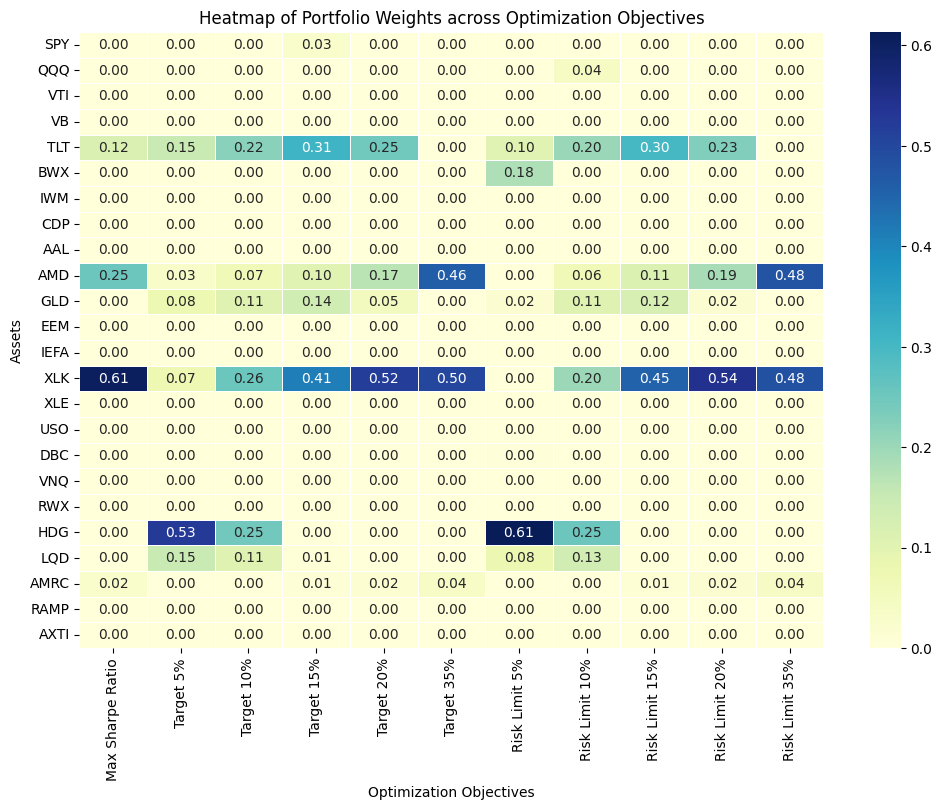

In [25]:
# Heatmap of Portfolio Weights across Optimization Objectives
plt.figure(figsize=(12, 8))
sns.heatmap(results.set_index("Assets"), annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Portfolio Weights across Optimization Objectives")
plt.xlabel("Optimization Objectives")
plt.ylabel("Assets")
plt.show()



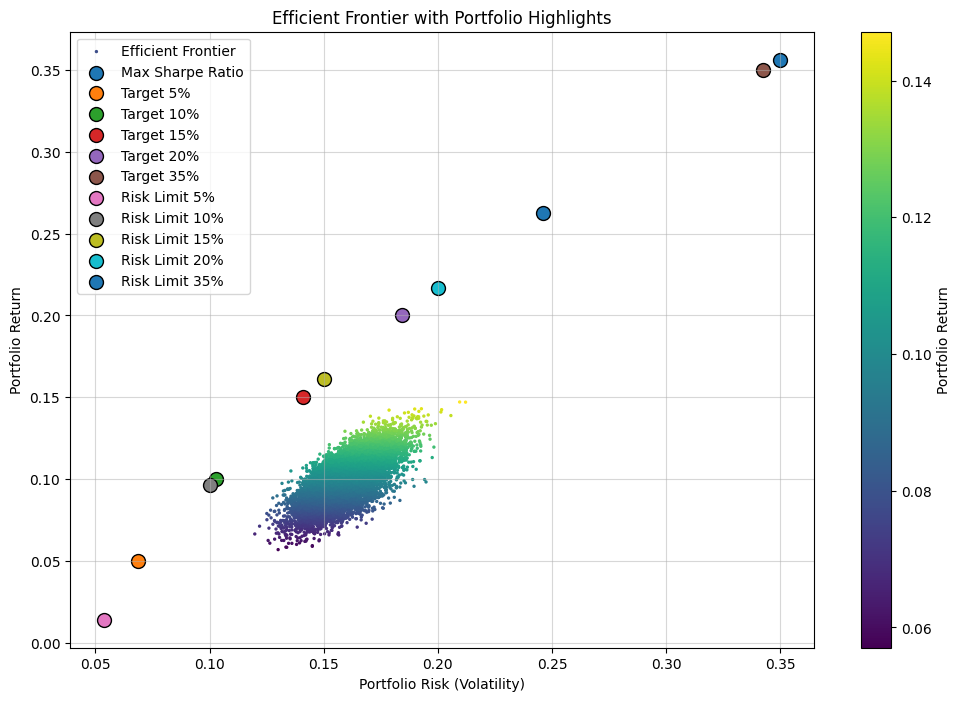

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Portfolio performance function
def portfolio_performance(weights, expected_returns, covariance_matrix):
    """
    Calculate portfolio return and risk.
    """
    weights = np.array(weights)  # Ensure weights are NumPy arrays
    portfolio_return = np.dot(weights, expected_returns)  # Scalar
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))  # Scalar
    return portfolio_return, portfolio_risk

# Generate Efficient Frontier
def generate_efficient_frontier(expected_returns, covariance_matrix, num_portfolios=10000):
    """
    Simulate random portfolios to create the efficient frontier.
    """
    portfolio_risks = []
    portfolio_returns = []
    num_assets = len(expected_returns)
    for _ in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        ret, risk = portfolio_performance(weights, expected_returns, covariance_matrix)
        portfolio_returns.append(ret)
        portfolio_risks.append(risk)
    return portfolio_risks, portfolio_returns

# Simulate the efficient frontier
risks, returns = generate_efficient_frontier(expected_returns, covariance_matrix)

# Ensure weights are NumPy arrays for the specific portfolios
your_portfolios = {
    "Max Sharpe Ratio": np.array(optimal_sharpe_weights),
    **{key: np.array(weights) for key, weights in min_risk_weights.items()},
    **{key: np.array(weights) for key, weights in max_return_weights.items()},
}

# Calculate performance metrics (risk and return) for each portfolio
your_portfolio_metrics = {}
for name, weights in your_portfolios.items():
    weights = np.array(weights)  # Ensure weights are NumPy arrays
    ret, risk = portfolio_performance(weights, expected_returns, covariance_matrix)
    your_portfolio_metrics[name] = (ret, risk)

# Plot Efficient Frontier
plt.figure(figsize=(12, 8))

# Plot the efficient frontier
plt.scatter(risks, returns, c=returns, cmap='viridis', s=2, label="Efficient Frontier")
plt.colorbar(label='Portfolio Return')

# Highlight your specific portfolios
for name, (ret, risk) in your_portfolio_metrics.items():
    plt.scatter([risk], [ret], label=name, s=100, marker='o', edgecolors='black')

# Add Labels and Legends
plt.title("Efficient Frontier with Portfolio Highlights")
plt.xlabel("Portfolio Risk (Volatility)")
plt.ylabel("Portfolio Return")
plt.grid(alpha=0.5)
plt.legend(loc="best", fontsize=10)
plt.show()


In [27]:
# Calculate performance metrics for all portfolios
performance_metrics = {
    name: {
        "Return": portfolio_performance(weights, expected_returns, covariance_matrix)[0],
        "Risk": portfolio_performance(weights, expected_returns, covariance_matrix)[1],
        "Sharpe Ratio": (portfolio_performance(weights, expected_returns, covariance_matrix)[0] - risk_free_rate) /
                        portfolio_performance(weights, expected_returns, covariance_matrix)[1]
    }
    for name, weights in your_portfolios.items()
}

# Convert to DataFrame for comparison
performance_df = pd.DataFrame(performance_metrics).T
print("\nPerformance Metrics for Portfolios:")
print(performance_df)



Performance Metrics for Portfolios:
                    Return      Risk  Sharpe Ratio
Max Sharpe Ratio  0.262638  0.245931      0.974003
Target 5%         0.050015  0.068821      0.391090
Target 10%        0.099989  0.102649      0.749043
Target 15%        0.150015  0.140819      0.901261
Target 20%        0.200024  0.184330      0.959821
Target 35%        0.349988  0.342404      0.954686
Risk Limit 5%     0.014237  0.053657     -0.165176
Risk Limit 10%    0.096316  0.099994      0.732203
Risk Limit 15%    0.161350  0.150000      0.921672
Risk Limit 20%    0.216541  0.200004      0.967188
Risk Limit 35%    0.356090  0.350006      0.951383
